In [1]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/jupyter/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [5]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [6]:
y_range = [0,5.5]

In [7]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


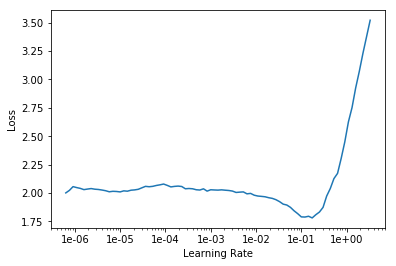

In [9]:
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss
1,1.610384,0.931290
2,0.844515,0.675658
3,0.646834,0.670073


In [11]:
preds = learn.get_preds()

In [14]:
scipy.stats.linregress(preds[0], preds[1])

LinregressResult(slope=1.0055009214364727, intercept=0.010378676571852541, rvalue=0.5392893403805334, pvalue=6.017993914643834e-92, stderr=0.04525031999195761)

## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [15]:
path=Path('/home/jupyter/.fastai/data/ml-100k/')

In [16]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [17]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [18]:
len(ratings)

100000

In [19]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [20]:
data = CollabDataBunch.from_df(rating_movie, seed=42, pct_val=0.1, item_name=title)

In [21]:
data.show_batch()

userId,title,target
527,Forrest Gump (1994),4.0
176,Cop Land (1997),3.0
329,"Peacemaker, The (1997)",2.0
374,"Godfather, The (1972)",4.0
194,Quiz Show (1994),4.0


In [22]:
y_range = [0,5.5]

In [23]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


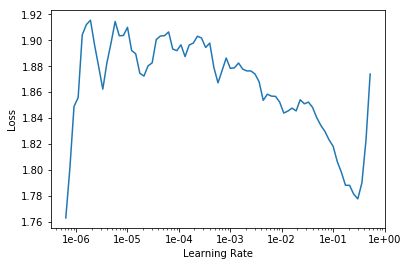

In [24]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [25]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,0.918793,0.936360
2,0.857485,0.890187
3,0.753056,0.833436
4,0.650088,0.813405
5,0.552315,0.811452


In [26]:
preds = learn.get_preds()

In [34]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [35]:
learn.load('dotprod');

In [36]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [37]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [38]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [39]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [40]:
item0 = lambda o:o[0]

In [41]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3255),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3013), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2909),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2794), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2642), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2456), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2306), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2286), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2278), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2231), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.2174), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2146), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2146), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2095), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.

In [42]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6043), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5899), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5679), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5539), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5515), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5500), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5453), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5245), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4946), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4940), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4883), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4726), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4572), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4502), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4489), 'To Kill a Mockingbird (1962)', 4.292237442922374)]

### Movie weights

In [48]:
learn.weight??

In [43]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [44]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [45]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [46]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.3022), 'Home Alone 3 (1997)'),
 (tensor(1.2466), 'Congo (1995)'),
 (tensor(1.2035), 'Jungle2Jungle (1997)'),
 (tensor(1.1908), "McHale's Navy (1997)"),
 (tensor(1.1771), 'Bio-Dome (1996)'),
 (tensor(1.1655), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.1291), 'Grease 2 (1982)'),
 (tensor(1.0836), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.0696), 'Leave It to Beaver (1997)'),
 (tensor(1.0431), 'Flipper (1996)')]

In [47]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1496), 'Wrong Trousers, The (1993)'),
 (tensor(-1.0370), 'Chinatown (1974)'),
 (tensor(-1.0279), 'Casablanca (1942)'),
 (tensor(-1.0077), 'Persuasion (1995)'),
 (tensor(-1.0055), 'Close Shave, A (1995)'),
 (tensor(-0.9886), 'When We Were Kings (1996)'),
 (tensor(-0.9837), 'Citizen Kane (1941)'),
 (tensor(-0.9768), 'Third Man, The (1949)'),
 (tensor(-0.9728), 'Lawrence of Arabia (1962)'),
 (tensor(-0.9715), 'Secrets & Lies (1996)')]

In [49]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [50]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8567), 'Keys to Tulsa (1997)'),
 (tensor(0.8225), 'Stupids, The (1996)'),
 (tensor(0.8224), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8095), 'Trainspotting (1996)'),
 (tensor(0.7825), 'Dead Man (1995)'),
 (tensor(0.7824), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7461), 'Cable Guy, The (1996)'),
 (tensor(0.7429), 'Crumb (1994)'),
 (tensor(0.7416), 'Very Brady Sequel, A (1996)'),
 (tensor(0.7363), 'Crow: City of Angels, The (1996)')]

In [51]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1647), 'Braveheart (1995)'),
 (tensor(-1.1279), 'Titanic (1997)'),
 (tensor(-1.0604), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.8704), 'Forrest Gump (1994)'),
 (tensor(-0.8612), 'Top Gun (1986)'),
 (tensor(-0.8554), "It's a Wonderful Life (1946)"),
 (tensor(-0.8328), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8131), 'American President, The (1995)'),
 (tensor(-0.8108), 'Pretty Woman (1990)'),
 (tensor(-0.7970), "Mr. Holland's Opus (1995)")]

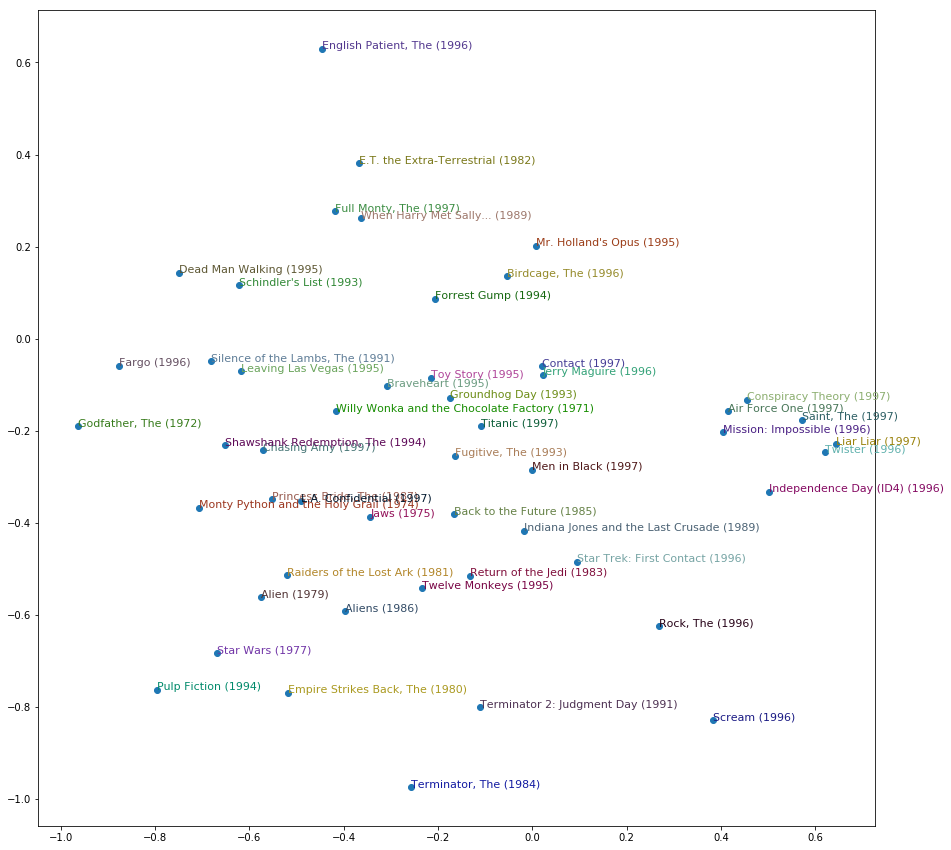

In [52]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()